In [167]:
import numpy as np
import functools
import math
from matplotlib import collections as mc
import xml.etree.ElementTree as ET
from collections import namedtuple
import csv
import pprint


In [168]:
# Load the XML file
tree = ET.parse('./data_72.xml')
root = tree.getroot()

# Extract information
dataset = root.find('./info/dataset').text
name = root.find('./info/name').text

Vertex = namedtuple("Vertex", ["id", "isWarehouse", "x", "y"])
Request = namedtuple("Request", ["id", "node_id", "quantity"])

In [169]:
car_type = None
for vehicle_profile in root.findall('./fleet/vehicle_profile'):
    departure_node = vehicle_profile.find('departure_node').text
    arrival_node = vehicle_profile.find('arrival_node').text
    capacity = vehicle_profile.find('capacity').text
    car_type = { 'departure_node': departure_node, 'arrival_node': arrival_node, 'capacity': capacity }


In [170]:

nodes = []
warehouse = None
for node in root.findall('./network/nodes/node'):
    node_id = node.attrib['id']
    node_type = node.attrib['type']
    cx = node.find('cx').text
    cy = node.find('cy').text

    if node_type == '0':
        warehouse = Vertex(node_id, True,  float(cx), float(cy))

    nodes.append((node_id, node_type, cx, cy))

assert warehouse is not None

vertices = {}
for node in nodes:
    if node[1] == '0':
        result = True
    else:
        result = False
    vertexid = int(node[0])
    vertices[vertexid] = (Vertex(vertexid, result,  float(node[2]), float(node[3])))


requests_list = []

for request in root.findall('./requests/request'):
    request_id = request.attrib['id']
    node = request.attrib['node']
    quantity = request.find('quantity').text
    requests_list.append({'Request ID': request_id, 'Node': node, 'Quantity': quantity})

requests_list

requests = {}
requests['1'] = (Request(-3, 1, -1))
for request in requests_list:
    requests[request['Request ID']] = (Request(int(request['Request ID']), int(request['Node']), float(request['Quantity'])))

requests

{'1': Request(id=1, node_id=2, quantity=7063.0),
 '2': Request(id=2, node_id=3, quantity=51.0),
 '3': Request(id=3, node_id=4, quantity=23.0),
 '4': Request(id=4, node_id=5, quantity=3074.0),
 '5': Request(id=5, node_id=6, quantity=349.0),
 '6': Request(id=6, node_id=7, quantity=1047.0),
 '7': Request(id=7, node_id=8, quantity=698.0),
 '8': Request(id=8, node_id=9, quantity=3001.0),
 '9': Request(id=9, node_id=10, quantity=31.0),
 '10': Request(id=10, node_id=11, quantity=1135.0),
 '11': Request(id=11, node_id=12, quantity=21611.0),
 '12': Request(id=12, node_id=13, quantity=57.0),
 '13': Request(id=13, node_id=14, quantity=51.0),
 '14': Request(id=14, node_id=15, quantity=551.0),
 '15': Request(id=15, node_id=16, quantity=179.0),
 '16': Request(id=16, node_id=17, quantity=6.0),
 '17': Request(id=17, node_id=18, quantity=528.0),
 '18': Request(id=18, node_id=19, quantity=2832.0),
 '19': Request(id=19, node_id=20, quantity=1514.0),
 '20': Request(id=20, node_id=21, quantity=889.0),
 '21

In [171]:
# Define the dictionaries
dictionaries = [requests, vertices]

# Print the first 5 elements of each dictionary
for dictionary in dictionaries:
    print("\n")
    print(*list(dictionary.items())[:5], sep="\n")




('1', Request(id=1, node_id=2, quantity=7063.0))
('2', Request(id=2, node_id=3, quantity=51.0))
('3', Request(id=3, node_id=4, quantity=23.0))
('4', Request(id=4, node_id=5, quantity=3074.0))
('5', Request(id=5, node_id=6, quantity=349.0))


(1, Vertex(id=1, isWarehouse=True, x=0.0, y=0.0))
(2, Vertex(id=2, isWarehouse=False, x=-12.0, y=-6.0))
(3, Vertex(id=3, isWarehouse=False, x=-15.0, y=-5.0))
(4, Vertex(id=4, isWarehouse=False, x=-1.0, y=-18.0))
(5, Vertex(id=5, isWarehouse=False, x=2.0, y=-21.0))


In [172]:
@functools.lru_cache(maxsize=None)
def distance_function(v1, v2):
    return math.sqrt(((v1.x - v2.x) * (v1.x - v2.x)) + ((v1.y - v2.y) * (v1.y - v2.y)))


def fitness_function(vertices, distance, solution):
    solution_distance = 0
    for x, y in zip(solution, solution[1:] + solution[0:1]):
        solution_distance += distance(x, y)
    
    return solution_distance

def initialize_pheromone(N):
    return 0.01 * np.ones(shape=(N,N))


def update_pheromone(pheromones_array, solutions, fitness_values, Q, rho):
    pheromone_update = np.zeros(shape=pheromones_array.shape)
    for solution, fitness_value in zip(solutions, fitness_values):
        for x, y in zip(solution, solution[1:] + solution[0:1]):
            pheromone_update[x.id, y.id] += Q / fitness_value
    
    return (1 - rho) * pheromones_array + pheromone_update

def generate_solutions(vertices, requests, pheromones, distance_function, number_of_ants, car_capacity, alpha=1, beta=3):
    
    # Probability of selecting v2 right after v1
    def compute_prob(v1, req):
        v2 = vertices[int(req)]
        distance = distance_function(v1, v2)
        
        # obezlicka, uvidime jestli to pofacha
        if(distance == 0):
            return 1e-6
        inverse_distance = 1 / distance 
        tau = pheromones[v1.id, v2.id]
        ret = pow(tau, alpha) * pow(inverse_distance, beta)
        return ret if ret > 1e-6 else 1e-6
    
    for _ in range(number_of_ants):
        remaining_requests = list(requests)
        solution = [vertices[1]]  # Start from the warehouse
        capacity = car_capacity
        #print(capacity)
        while len(remaining_requests) > 1:
            probs = np.array([compute_prob(solution[-1], req) for req in remaining_requests])
            probs /= probs.sum()  # Normalize probabilities
            
            selected_index = np.random.choice(len(remaining_requests), p=probs)
            selected_request = remaining_requests[selected_index]
            request = requests[selected_request]
            new_request_capacity = request.quantity

            selected_vertex = vertices[int(selected_request)]
            print("remaining count: ", len(remaining_requests))
            # Check if adding the selected request exceeds the capacity
            if selected_vertex.isWarehouse:
                # Revisit the warehouse if capacity is exhausted
                solution.append(selected_vertex)
                capacity = car_capacity
                #print("Going back to the warehouse")
            
            elif capacity - request.quantity >= 0:
                solution.append(selected_vertex)
                remaining_requests.remove(selected_request)
                capacity -= request.quantity  # Decrement capacity
            else:
                solution.append(selected_vertex)

            # print(capacity)
        # Return to the warehouse after serving all requests
        solution.append(vertices[1])
        
        yield solution


def ant_solver(vertices, distance_function, number_of_ants=10, max_iterations=200, alpha=1, beta=3, Q=100, rho=0.8):
    pheromones = initialize_pheromone(len(vertices))
    best_solution = None
    best_fitness = float("inf")
    log_of_best_distances = list()
    
    print("Iteration\tMinimum value\tMean value\tMaximum value")
    
    for i in range(max_iterations):
        candidate_solutions = list(generate_solutions(vertices, requests, pheromones, distance_function, number_of_ants, float(car_type['capacity']), alpha=alpha, beta=beta))
        fitness_values = list(map(lambda x: fitness_function(vertices, distance_function, x), candidate_solutions))
        pheromones = update_pheromone(pheromones, candidate_solutions, fitness_values, Q=Q, rho=rho)
        
        for candidate_solution, fitness_value in zip(candidate_solutions, fitness_values):
            if fitness_value < best_fitness:
                best_fitness = fitness_value
                best_solution = candidate_solution
                
        log_of_best_distances.append(np.min(fitness_values))
        
        print(f"{i:8}:\t{np.min(fitness_values):5.8f}\t{np.mean(fitness_values):5.8f}\t{np.max(fitness_values):5.8f}")
    return best_solution, pheromones, log_of_best_distances
print("Request count: ", len(requests))
print("Vertex count: ", len(vertices))
best_solution, pheromones, log_of_best_distances = ant_solver(vertices, distance_function)


Request count:  71
Vertex count:  72
Iteration	Minimum value	Mean value	Maximum value
remaining count:  71
remaining count:  70
remaining count:  69
remaining count:  68
remaining count:  67
remaining count:  66
remaining count:  65
remaining count:  64
remaining count:  63
remaining count:  62
remaining count:  61
remaining count:  60
remaining count:  59
remaining count:  58
remaining count:  57
remaining count:  56
remaining count:  55
remaining count:  54
remaining count:  53
remaining count:  52
remaining count:  51
remaining count:  50
remaining count:  49
remaining count:  48
remaining count:  47
remaining count:  46
remaining count:  45
remaining count:  44
remaining count:  43
remaining count:  43
remaining count:  42
remaining count:  41
remaining count:  40
remaining count:  39
remaining count:  38
remaining count:  37
remaining count:  36
remaining count:  35
remaining count:  34
remaining count:  33
remaining count:  32
remaining count:  31
remaining count:  30
remaining c

KeyboardInterrupt: 

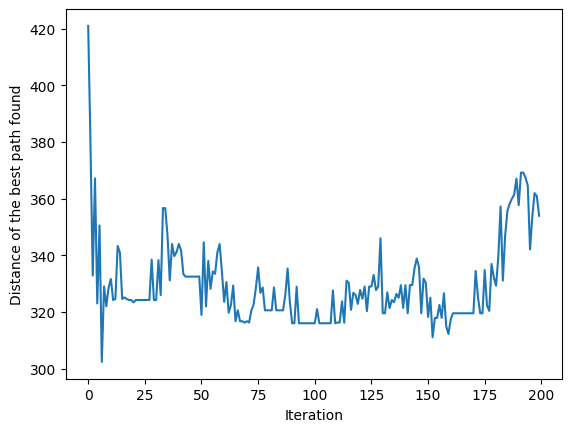

In [ ]:
from matplotlib import pyplot as plt

plt.plot(log_of_best_distances)
plt.ylabel("Distance of the best path found")
plt.xlabel("Iteration")
plt.show()

Fitness:  302.4242294113173


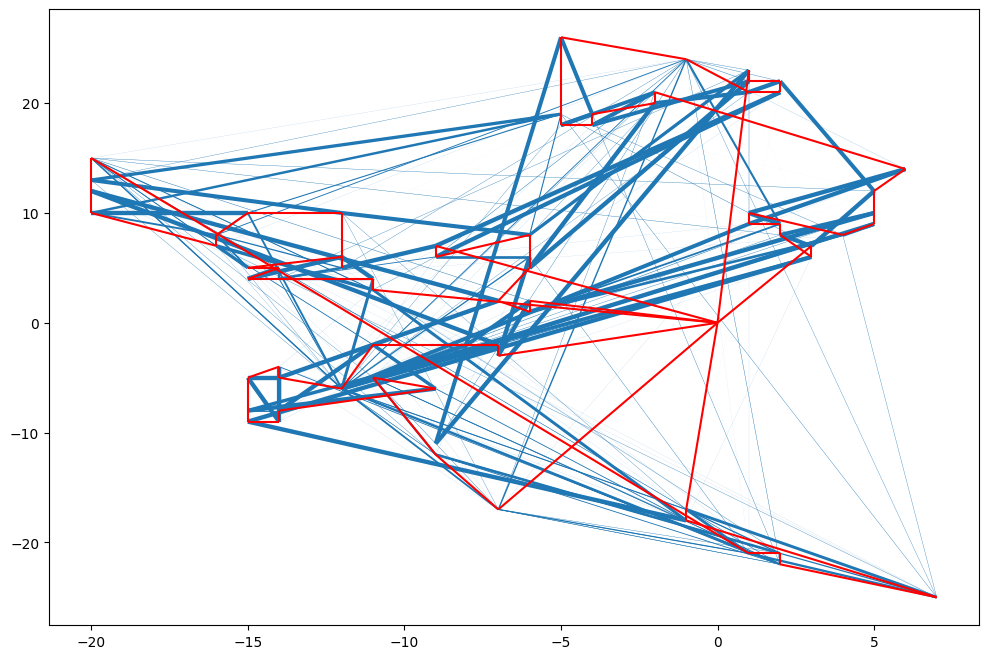

[Vertex(id=1, isWarehouse=True, x=0.0, y=0.0),
 Vertex(id=30, isWarehouse=False, x=3.0, y=7.0),
 Vertex(id=21, isWarehouse=False, x=3.0, y=6.0),
 Vertex(id=24, isWarehouse=False, x=2.0, y=8.0),
 Vertex(id=27, isWarehouse=False, x=2.0, y=9.0),
 Vertex(id=25, isWarehouse=False, x=1.0, y=9.0),
 Vertex(id=26, isWarehouse=False, x=1.0, y=10.0),
 Vertex(id=31, isWarehouse=False, x=4.0, y=8.0),
 Vertex(id=22, isWarehouse=False, x=5.0, y=9.0),
 Vertex(id=23, isWarehouse=False, x=5.0, y=10.0),
 Vertex(id=29, isWarehouse=False, x=5.0, y=12.0),
 Vertex(id=28, isWarehouse=False, x=6.0, y=14.0),
 Vertex(id=49, isWarehouse=False, x=-2.0, y=21.0),
 Vertex(id=48, isWarehouse=False, x=-2.0, y=20.0),
 Vertex(id=51, isWarehouse=False, x=-4.0, y=19.0),
 Vertex(id=50, isWarehouse=False, x=-4.0, y=18.0),
 Vertex(id=52, isWarehouse=False, x=-5.0, y=18.0),
 Vertex(id=71, isWarehouse=False, x=-5.0, y=19.0),
 Vertex(id=53, isWarehouse=False, x=-5.0, y=26.0),
 Vertex(id=46, isWarehouse=False, x=-1.0, y=24.0),
 V

In [ ]:
# Render pheromones (blue, line width corresponds to the pheromon value on the edge)
lines = []
colors = []
for i, v1 in enumerate(vertices):
    for j, v2 in enumerate(vertices):
        lines.append([(vertices[v1].x, vertices[v1].y), (vertices[v2].x, vertices[v2].y)])
        colors.append(pheromones[i, j])

lc = mc.LineCollection(lines, linewidths=np.array(colors))

plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.add_collection(lc)
ax.autoscale()

solution = best_solution

# Here, you can test the influence of the individual parameters on the generated candidate solution
# solution = list(generate_solutions(vertices, pheromones, distance_function, number_of_ants=1, alpha=3, beta=1))[0]

# Print solution's fitness
print("Fitness: ", fitness_function(vertices, distance_function, solution))

# Render the solution (red)
solution_lines = []
for i, j in zip(solution, solution[1:] + solution[0:1]):
    solution_lines.append([(i.x, i.y), (j.x, j.y)])

solutions_lc = mc.LineCollection(solution_lines, colors="red")

ax.add_collection(solutions_lc)

plt.show()

# Print towns in the order of the soultion
solution_vertices = [i for i in solution]
pprint.pprint(solution_vertices)